A MODEL
========

This model is the simple approach of trying to classify the different records independently. It simply gets every ocurrence as an indepent one. 

The different writtings are put trhough an TF-IDF tokenizer, this will be the input to the next stages.

The tokenized data is then put trough a Neural Network model, which will learn from it to later classify the server occurrences.

Initialization of the Environment
==========================

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np
import collections
import tensorflow as tf
import os

np.random.seed(1)
tf.set_random_seed(2)

Load Data
========

In [0]:
import xml.etree.ElementTree as ET
import csv
import pandas as pd

In [0]:
SST_HOME='drive/My Drive/Colab Notebooks/Erisk2019/'
path_train=SST_HOME+'datas/training data - t1/2018 train/train.csv'
path_test=SST_HOME+'datas/training data - t1/2018 test/test.csv'

In [0]:
def listdir_fulllpath(d):
  return [os.path.join(d, f) for f in os.listdir(d)]

In [0]:
def parse_subject(path_xml):
  """
  This function will take the xmls return a pandas df.
  """
  tree = ET.parse(path_xml)
  root = tree.getroot()
  
  subject_id = root.find('ID').text
  writings = []
  
  # Read the xml
  for writing in root.findall('WRITING'):
    writing_data = {}
    writing_data['ID'] = subject_id
    writing_data['TITLE'] = writing.find('TITLE').text
    writing_data['DATE'] = writing.find('DATE').text
    writing_data['INFO'] = writing.find('INFO').text 
    writing_data['TEXT'] = writing.find('TEXT').text
    
    writings.append(writing_data)
    
  df = pd.DataFrame(writings)
  # If the record has no id or date return none
  try:
    df = df.set_index(['ID', 'DATE'])
  except:
    return None
  
  return df


def parse_folder(path_folder):
  """
  This function will parse a whole folder worth of records.
  
  Returns the records as a csv.
  """
  # Look for all the files in the directory
  files = []
  for f in os.listdir(path_folder):
      file_path = os.path.join(path_folder, f)
      if os.path.isfile(file_path):
        files.append(file_path)
  
  # Parse the xmls to pandas dataframes
  frames = [parse_subject(f) for f in files]
  
  # Merge the frames
  return pd.concat(frames)
  
def records_to_csv(path_records, path_csv, load=False):
  """
  This function will parse all the records into a csv
  """
  if load:
    if os.path.exists(path_csv):
      return pd.read_csv(path_csv).set_index(['ID', 'DATE'])
    else:
      print("File not found, can't load")
    
  
  frames = []
  test = False
  for f in listdir_fulllpath(path_records):
    
    # check if it is a test folder.
    if 'test' in f:
      test = True
      
    if os.path.isdir(f):
      for j in listdir_fulllpath(f):
        if os.path.isdir(j):
          frames.append(parse_folder(j))
          
  df = pd.concat(frames).sort_index()
  
  with open(path_records + 'risk_golden_truth.txt' if not test else path_records + 'risk-golden-truth-test.txt') as gt:
    df["LABEL"] = np.nan
    for line in gt:
      
      # The file ends with a newline, dont really know why
      if line == '\n':
        break
      
      rec_id, value = line.split()

      df.loc[rec_id, 'LABEL'] = value
      
  df.to_csv(path_csv)
  return df

In [0]:
print('started')
train_df = records_to_csv(SST_HOME+'datas/training data - t1/2018 train/', path_train, load=True)
print('completed train')
test_df = records_to_csv(SST_HOME+'datas/training data - t1/2018 test/', path_test, load=True)
print('completed test')

started
completed train
completed test


In [0]:
print(len(test_df), len(train_df))

168507 84834


In [0]:
train_df.columns

Index(['INFO', 'TEXT', 'TITLE', 'LABEL'], dtype='object')

In [0]:
train_x = [text + title for text, title in train_df[["TEXT", "TITLE"]].values]
train_y = train_df["LABEL"].values

test_x = [text + title for text, title in test_df[["TEXT", "TITLE"]].values]
test_y = test_df["LABEL"].values

In [0]:
train_balance = collections.Counter(train_y)
test_balance = collections.Counter(test_y)

print(train_balance)
print(test_balance)

Counter({0: 77382, 1: 7452})
Counter({0: 151085, 1: 17422})


In [0]:
users = train_df.index.get_level_values('ID').unique()
users_test = test_df.index.get_level_values('ID').unique()

writtings_per_user_train = [len(train_df.loc[user]) for user in users]
writtings_per_user_test = [len(test_df.loc[user]) for user in users_test]

In [0]:
import matplotlib.pyplot as plt

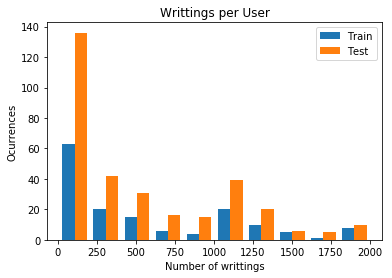

In [0]:
plt.hist([writtings_per_user_train, writtings_per_user_test], bins=10, label=["Train", "Test"])
plt.legend(loc='upper right')
plt.title("Writtings per User")
plt.xlabel("Number of writtings")
plt.ylabel("Ocurrences")
plt.savefig(SST_HOME + 'writtings_per_user.eps', metadata="eps")

In [0]:
 date_df = pd.read_csv(path_train).set_index(['DATE'])
  
 date_df_valid = pd.read_csv(path_test).set_index(['DATE'])

In [0]:
train_writtings_user = [len(date_df[date_df["ID"] == subject]) for subject in date_df['ID'].unique()]
valid_writtings_user = [len(date_df_valid[date_df_valid["ID"] == subject]) for subject in date_df_valid['ID'].unique()]
total_writtings = train_writtings_user + valid_writtings_user

In [0]:
number_users_test = len(test_df.index.get_level_values('ID').unique())
number_users_train = len(train_df.index.get_level_values('ID').unique())

In [0]:
number_users_train + number_users_test

472

In [0]:
number_users_test

320

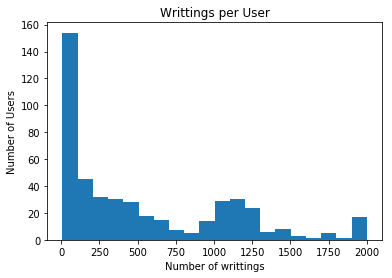

In [0]:
plt.hist(total_writtings, bins=20, cumulative=False)
plt.title("Writtings per User")
plt.xlabel("Number of writtings")
plt.ylabel("Number of Users")
plt.savefig(SST_HOME + 'writtings_per_user.png', dpi=300)#, metadata="eps")

Tokenizing the texts
================

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words=stopwords.words('english')
# Define maximum vocabulary length
MAX_WORDS = 5000

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# We are using this function to clean the test set
def tokenize_clean_text(text, tfidf=True, tokenizer=None, max_length=None, max_words=MAX_WORDS):
  """
  This function is in charge of tokenizing the text it is given. It also cleans
  the text from stop-words, punctuation, and gives a special token to numbers.
  
  :param text: The texts to tokenize in a bidimensional python array.
  
  :returns: The tokenized and cleaned text in a bidimensional python array.
            The tokenizer used to preprocess the text.
            The maximum length used for padding.
  """   
  # set [removed] as a special token
  text_removed = [t.replace("[removed]", "R3MOV3D") for t in text]
  
  # We remove the numbers
  cropped_numbers_text = [" ".join([word if not word.isdigit() else ""
                                for word in sentence.split()])
                               for sentence in text_removed]
  
  # Delete stopwords as well as every word less than 3 chars.
  cropped_numbers_stopw_text = [" ".join([word if not (word in stop_words or len(word) <= 3) else ""
                                      for word in sentence.split()])
                                     for sentence in cropped_numbers_text]
  
  if tfidf:
    vec = TfidfVectorizer(max_features=max_words)
    tfidf_mat = vec.fit_transform(cropped_numbers_stopw_text).toarray()
    tfid_words = vec.get_feature_names()

    cropped_numbers_stopw_tfidf_text = [" ".join([word if word in tfid_words else ""
                                            for word in sentence.split()])
                                            for sentence in cropped_numbers_stopw_text]
  
  if tokenizer is None:
    tokenizer = Tokenizer(num_words=max_words) # They use 5k words too
    tokenizer.fit_on_texts(cropped_numbers_stopw_tfidf_text if tfidf else cropped_numbers_stopw_text)
  # We tokenize the sentences
  tokenized_text = tokenizer.texts_to_sequences(cropped_numbers_stopw_tfidf_text if tfidf else cropped_numbers_stopw_text)
  
  if max_length == None:
    max_length = 0
    for sentence in tokenized_text:
      max_length = max_length if len(sentence) < max_length else len(sentence)
  
  # Now we return the padded the sequences.
  return pad_sequences(tokenized_text, max_length), tokenizer, max_length, cropped_numbers_stopw_tfidf_text if tfidf else cropped_numbers_stopw_text
  

In [0]:
train_x_token, tokenizer, max_length, train_x_clean = tokenize_clean_text(train_x) 
test_x_token, _, _, test_x_clean = tokenize_clean_text(test_x, tokenizer=tokenizer)

In [0]:
token_index = np.unique(train_x_token)

In [0]:
max_words = len(token_index)

In [0]:
max_words

In [0]:
import matplotlib.pyplot as plt

lengths  = np.array([len(sentence.split()) for sentence in test_x_clean if len(sentence.split()) < 400000])
plt.hist(lengths, bins=100, cumulative = True)
plt.title("TFIDF text")
plt.xlabel("Length")
plt.ylabel("Ocurrences")
plt.savefig(SST_HOME + 'a_text_hist.eps', metadata="eps")

In [0]:
# the length will be set to 100
max_length = 50
train_x_token = train_x_token[:,-max_length:]
test_x_token = test_x_token[:,-max_length:]

Neural networks
=============

In [0]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Activation, Embedding, Dropout, Input
from keras.layers import Lambda, Flatten, RepeatVector, Permute, Multiply
from keras.layers import LSTM, GRU, Bidirectional, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Concatenate

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop, Adam

# **TensorBoard**
TensorBoard is a great tool for DL visualization. It shows the evolution of metrics during the training phase, as well as the weights, distributions, and even the graph of the neural net. 

We will be using tensorboardcolab in order to run a 
TensorBoard instance. This will initialize a ngrok machine and launch TensorBoard for us to see. 

TensorBoard will be accesible by the url 

In [0]:
# We install tensorboard colab in case we don't have it already.
!pip install tensorboardcolab

In [0]:
import tensorboardcolab as tb

tbc=tb.TensorBoardColab()

Experiments Configuration
=====================

In [0]:
# load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
tfidf = [True]
concept_emb = [True]
load_emb = [False]
num_classes = [None]
emb_size = [300]
trainable_emb = [True]
cnn_size = [[None]] # [[128], [128, 128], [512]]
cnn_filter = [[3]]
rnn_size = [[64], [128]]
cell_type = [LSTM, GRU]
bidirectional = [False]
attention = [True, False]
dropout = [0.5]
dnn_size = [[32], [128, 32], [512]]
batch_size = [1024]

indexes = ["load_emb", "emb_size", "trainable_emb", "cnn_size", "cnn_filter", "rnn_size", "cell_type", "bidirectional", "attention", "dropout", "dnn_size", "batch_size"]
param   = [load_emb, emb_size, trainable_emb, cnn_size, cnn_filter, rnn_size, cell_type, bidirectional, attention, dropout, dnn_size, batch_size]

In [0]:
import itertools

def combine_params(param, indexes):
  """
  This function is in charge of combining the parameters. This way we can perform a grid search automatically.
  
  Inputs: The array of different parameters, and the indexes for them.
  
  Outputs: The dictionary of different configurations made.
  """
  combinations = list(itertools.product(*param))
  param_combinations = [{k:v for k, v in zip(indexes, combination)}  for combination in combinations]
  for p in param_combinations:
    # The embeddings size must adapt to the embeddings loaded.
    if p["load_emb"]:
      p["emb_size"] = None
    else:
      p["embedding_matrix"] = None
  return param_combinations

In [0]:
network_parameters = combine_params(param, indexes)

In [0]:
# We change the number of classes automatically
for p in network_parameters:
  p["max_length"] = max_length
  p["max_words"] = max_words
  try:
    p["num_classes"] = train_y.shape[1]
  except IndexError:
    p["num_classes"] = 1

# Load the embeddings

In this step, we load the word embeddings from the wikipedia, pubmed and PMC. Then we filter them adapting to the words we have in our dataset. This is, if the word appears in the pubmed we take its weights, which are set to 0 otherwise.

In [0]:
# seemingly gensim is not installed in google colab
!pip install gensim

In [0]:
from gensim.models.keyedvectors import KeyedVectors

#TODO
# Get social media embeddings

PATH_W2V = SST_HOME + "DL/w2v/wikipedia-pubmed-and-PMC-w2v.bin"

In [0]:
def load_W2V_model(path, binary):
    model = KeyedVectors.load_word2vec_format(path, binary=binary)
    print("Binary : {}".format(binary))
    print("Loaded W2V model")
    return model
  
def generate_embedding_weigths(word_index, max_words, model, binary=False):
  # We initialize the embd matrix as random
  # embedding_matrix = np.zeros((max_words, model.vector_size), dtype=np.float32)
  embedding_matrix = np.random.rand(max_words, model.vector_size)
  d_cuid = text_to_dict(PATH_CUID)
  d_str = text_to_dict(PATH_STRD, reverse=True)
  hit = 0
  for word, i in word_index.items():
    if i >= max_words:
        break
    if not binary:
      try:
        word = d_cuid[word]
      except KeyError:
        continue
    if word in model:
        # words not found in embedding index will be randomly initialized.
        embedding_matrix[i] = model[word]
        hit += 1
  print("Hits: {}\nTotal: {}".format(hit, i))

  return embedding_matrix

def generate_concept_embd_weights(tokens, max_words, model):
  embedding_matrix = np.random.rand(max_words, model.vector_size)
  d_cuid = text_to_dict(PATH_CUID)
  
  hit = 0
  for i, word in enumerate(tokens):
    if i >= max_words:
        break
    try:
      word = d_cuid[word]
    except KeyError:
      continue
      
    if word in model:
        # words not found in embedding index will be randomly initialized.
        embedding_matrix[i] = model[word]
        hit += 1
  print("Hits: {}\nTotal: {}".format(hit, i))

  return embedding_matrix


In [0]:
 
if any([p["load_emb"] for p in network_parameters]):
  binary = True if PATH_W2V[-3:]=="bin" else False
  if not 'model' in locals():
    model = load_W2V_model(PATH_W2V, binary)
  # Generate the weights matrix
  
  if any([p["concept_emb"] for p in network_parameters]):
    p = [p for p in network_parameters if p["concept_emb"]][0]
    embedding_matrix_concept = generate_concept_embd_weights(concept_tokens, p["max_words"], model)
        
  else:
    if any([p["tfidf"] and p["load_emb"] for p in network_parameters]):
      p = [p for p in network_parameters if p["tfidf"]][0]
      embedding_matrix_tfidf = generate_embedding_weigths(tokenizer_tfidf.word_index, p["max_words"], model, binary=binary)
    if any([(not p["tfidf"]) and p["load_emb"] for p in network_parameters]):
      p = [p for p in network_parameters if not p["tfidf"]][0]
      embedding_matrix = generate_embedding_weigths(tokenizer.word_index, p["max_words"], model, binary=binary)

  for p in network_parameters:
    if p["load_emb"]: 
      p["emb_size"] = model.vector_size
      p["embedding_matrix"] = embedding_matrix_concept if p["concept_emb"] else embedding_matrix if not p["tfidf"] else embedding_matrix_tfidf


Neural Network
=============

In [0]:
def add_embeddings(z, load, size, trainable, vocab_size, max_length, embedding_matrix): 
  """
  This method adds embeddings to the network.
  
  Returns the net with the embeddings added.
  """
  if load:
    z = Embedding(vocab_size, size, input_length=max_length, weights=[embedding_matrix], trainable=trainable)(z)
  else:
    z = Embedding(vocab_size, size, input_length=max_length)(z)
    
  return z

def add_cnn(z, size, filter_sizes, flatten):
  """
  This method adds the CNN layers to the network.
  
  Returns the net with the CNN layers.
  """
  conv_blocks = []
  for filter_size in filter_sizes:
    if filter_size is None:
      return z
    conv = None
    for i, cnn_layer in enumerate(size):
      if cnn_layer is None:
        return z
      conv = Conv1D(cnn_layer, filter_size, padding='valid', activation='relu', strides=1)(z if conv is None else conv)
      # if (i + 1)  % 2 == 0:
      conv = MaxPooling1D(pool_size=filter_size)(conv)        
      
    if flatten:
      conv = Flatten()(conv)
    conv_blocks.append(conv)         
 
  z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
  
  return z

def add_rnn(z, size, bidirectional, cell_type, attention):
  """
  This method adds the RNN layers to the network. It also adds an attention layer if intended.
  
  Returns the net with the RNN & Attention added.
  """
  for i, rsz in enumerate(size):
    if rsz is None:
      return z
    if not bidirectional:
      if i < len(size) - 1:
        z = cell_type(rsz, return_sequences=True)(z)
      else:
        z = cell_type(rsz, return_sequences=attention)(z)
    else:
      if i < len(size) - 1:
        z = Bidirectional(cell_type(rsz, return_sequences=True))(z)
      else:
        z = Bidirectional(cell_type(rsz, return_sequences=attention))(z)

  if attention:
    z = add_attention(z)

  return z

def add_dnn(z, size, dropout, activation="relu"):
  """
  This method adds the DNN layers to the network.
  
  Returns the net with the DNN layers added.
  """
  for fsz in size:
    if fsz is None:
      return z

    z = Dense(fsz, activation=activation)(z)
    z = Dropout(dropout)(z)
    
  return z

def add_attention(activations):
  """
  This method adds an attention layer.
  
  Returns the model with the attention layer.
  """
  
  size =  K.int_shape(activations)[-1]
  attention = BatchNormalization()(activations)
  attention = Dense(1, activation='tanh')(attention)
  attention = Flatten()(attention)
  attention = Activation('softmax')(attention)
  attention = RepeatVector(size)(attention)
  attention = Permute([2, 1])(attention)
  
  z = Multiply()([activations, attention])
  z = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(size,))(z)

  return z

In [0]:
def create_model(params):
  """
  This method creates a network model with the parameters given.
  
  Returns the uncompiled model.
  """
  inputs = Input(name='inputs',shape=(params["max_length"],))
  
  z = add_embeddings(inputs, params["load_emb"], params["emb_size"], params["trainable_emb"], params["max_words"] ,params["max_length"], params["embedding_matrix"])
  
  z = add_cnn(z, params["cnn_size"], params["cnn_filter"], [None] == params["rnn_size"])
  
  z = add_rnn(z, params["rnn_size"], params["bidirectional"], params["cell_type"], params["attention"])
  
  z = add_dnn(z, params["dnn_size"], params["dropout"])
  
  outputs = Dense(params["num_classes"], activation='sigmoid', name='output_layer')(z)
  
  net_model = Model(inputs=inputs,outputs=outputs)
  
  return net_model

In [0]:
def create_models(network_parameters, verbose=False):
  model_list = []
  for net_p in network_parameters:
    m = create_model(net_p)
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    model_list.append(m)
    
    if verbose:
      m.summary()
      
  return model_list

In [0]:
model_list = create_models(network_parameters, verbose=True)

# TB Colab Callback
We rewrite the tensorboardcolab callbacks to create different sessions depending on the variables our trainings have. This helps to differentiate the models in tensorboard.

In [0]:
import os
from keras.callbacks import TensorBoard
import tensorflow as tf

class TensorBoardColabCallback(TensorBoard):
    def __init__(self, tbc=None, write_graph=True, name=None, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'

        if tbc is None:
            return

        log_dir = tbc.get_graph_path()

        training_log_dir = os.path.join(log_dir, 'training_{}'.format(name))
        super(TensorBoardColabCallback, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation_{}'.format(name))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TensorBoardColabCallback, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}

        for name, value in val_logs.items():
            # print('val_logs:',epoch, name, value)
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TensorBoardColabCallback, self).on_epoch_end(epoch, logs)
        
    def on_train_end(self, logs=None):
        super(TensorBoardColabCallback, self).on_train_end(logs)
        self.val_writer.close()

tb.TensorBoardColabCallback = TensorBoardColabCallback

In [0]:
def define_callbacks(name):
  # Define the callbacks
  tbc_callback = tb.TensorBoardColabCallback(tbc, name=name)  # , histogram_freq=1)
   
  callbacks = [
      ReduceLROnPlateau(patience=1),
      EarlyStopping(patience=4),
      tbc_callback
  ]
  return callbacks

In [0]:
# Create an array of names
network_names = []
for p in network_parameters:
  name = "load_emb_{}_num_classes_{}_emb_size_{}_trainable_emb_{}_cnn_size_{}_cnn_filter_{}_pool_rnn_size_{}_cell_type_{}_bidirectional_{}_attention_{}_dropout_{}_dnn_size_{}_batch_size_{}".format(
      p["load_emb"], p["num_classes"], p["emb_size"], p["trainable_emb"], p["cnn_size"], p["cnn_filter"], p["rnn_size"], 
      str(p["cell_type"]).split(".")[-1].replace("'", "").replace(">", ""), p["bidirectional"],
      p["attention"], p["dropout"], p["dnn_size"], p["batch_size"])
  name = name.replace(" ", "").replace("[", "").replace("]", "").replace(",", "-")
  network_names.append(name)

Train Models
==========

In [0]:
from keras.models import load_model
for i, net_model in enumerate(model_list):
  # Set a name for the model based on the tweaked parameters
  p = network_parameters[i]
  name = network_names[i]
  model_path = SST_HOME+"DL/models/A/" + name

  # If the model exists, don't compute it again.
  #if os.path.isfile(model_path):
  #   continue
    
  print("\n\n********************************************\n")    
  print(name)
  callbacks = define_callbacks(name)
  # Fit the model and extract its data
  try:
    history = net_model.fit(train_x_token, train_y, epochs=20, batch_size=network_parameters[i]["batch_size"], 
                            callbacks=callbacks, class_weight={0: 0.11, 1: 0.89}, # Classes are weighted proportionally.
                            validation_split=0.25)
  except Exception as e:
    print("Could not Train Model")
    print(Exception)
    continue
    
  # And save the model
  net_model.save(model_path)
  
# To free memory from the gpu
from keras import backend as K
K.clear_session()



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_32_batch_size_1024
Train on 63625 samples, validate on 21209 samples


W0618 16:52:58.084383 140458267318144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0618 16:52:58.086107 140458267318144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
63625/63625 [==============================] - 91s 1ms/step - loss: 0.0779 - binary_accuracy: 0.9497 - val_loss: 0.3071 - val_binary_accuracy: 0.7579
Epoch 2/20
63625/63625 [==============================] - 87s 1ms/step - loss: 0.0731 - binary_accuracy: 0.9606 - val_loss: 0.2748 - val_binary_accuracy: 0.7910
Epoch 3/20
63625/63625 [==============================] - 87s 1ms/step - loss: 0.0682 - binary_accuracy: 0.9473 - val_loss: 0.2910 - val_binary_accuracy: 0.7868
Epoch 4/20
63625/63625 [==============================] - 87s 1ms/step - loss: 0.0626 - binary_accuracy: 0.9464 - val_loss: 0.3270 - val_binary_accuracy: 0.7840


********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_128-32_batch_size_1024
Train on 63625 samples, validate on 21209 samples
Epoch 1/20
63625/63625 [==============================] - 8

Evaluation
========

In [0]:
from keras.models import load_model

In [0]:
for trheshold in np.arange(0.1, 1.1, 0.1):
# trheshold = 0.2
  print("THRESHOLD: {}\n**********************".format(trheshold))
  from sklearn.metrics import classification_report
  predictions_list = []
  for i, net_model in enumerate(model_list):
    print("\n\n********************************************\n")
    print(network_names[i])
    model_path = SST_HOME+"DL/models/A/" + network_names[i]
    try:
      net_model = load_model(model_path)
    except ValueError:
      print("The model {} was not loaded correctly".format(name))
      continue
    except OSError:
      print("The model does not exist")
      continue

    predictions = net_model.predict(test_x_token)
    predictions = np.array([0 if prediction < trheshold else 1 for prediction in predictions])
    predictions_list.append(predictions)
    # measuring performance on test set
    cr=classification_report(test_y, predictions)
    print(cr)
    # Release memory
    K.clear_session()

THRESHOLD: 0.1
**********************


********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.90      0.01      0.02    151085
           1       0.10      0.99      0.19     17422

    accuracy                           0.11    168507
   macro avg       0.50      0.50      0.10    168507
weighted avg       0.82      0.11      0.03    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_128-32_batch_size_1024
              precision    recall  f1-score   support

           0       0.89      0.19      0.31    151085
           1       0.10      0.79   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_512_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_512_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_GRU_bidirectional_False_attention_True_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_GRU_bidirectional_False_attention_True_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_GRU_bidirectional_False_attention_True_dropout_0.5_dnn_size_512_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_GRU_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_GRU_bidirectional_False_attention_False_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_64_cell_type_GRU_bidirectional_False_attention_False_dropout_0.5_dnn_size_512_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_LSTM_bidirectional_False_attention_True_dropout_0.5_dnn_size_512_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_512_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_GRU_bidirectional_False_attention_True_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_GRU_bidirectional_False_attention_True_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_GRU_bidirectional_False_attention_True_dropout_0.5_dnn_size_512_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_GRU_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_GRU_bidirectional_False_attention_False_dropout_0.5_dnn_size_128-32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



********************************************

load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_None_cnn_filter_3_pool_rnn_size_128_cell_type_GRU_bidirectional_False_attention_False_dropout_0.5_dnn_size_512_batch_size_1024
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
for trheshold in np.arange(0.1, 1.1, 0.1):
# trheshold = 0.2
  print("THRESHOLD: {}\n**********************".format(trheshold))
  from sklearn.metrics import classification_report
  predictions_list = []
  i = 0
  network_names[i] = "Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024"
  
  print(network_names[i])
  model_path = SST_HOME+"DL/models/A/best_models/" + network_names[i]
  try:
    net_model = load_model(model_path)
  except ValueError:
    print("The model {} was not loaded correctly".format(name))
    continue
  except OSError:
    print("The model does not exist")
    continue

  predictions = net_model.predict(test_x_token)
  predictions = np.array([0 if prediction < trheshold else 1 for prediction in predictions])
  predictions_list.append(predictions)
  # measuring performance on test set
  cr=classification_report(test_y, predictions)
  print(cr)
  # Release memory
  K.clear_session()

THRESHOLD: 0.1
**********************
Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.93      0.14      0.25    151085
           1       0.11      0.91      0.19     17422

    accuracy                           0.22    168507
   macro avg       0.52      0.53      0.22    168507
weighted avg       0.85      0.22      0.24    168507

THRESHOLD: 0.2
**********************
Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.93      0.68      0.78    151085
           1       0.16      0.55      0.25     17422

    accuracy                   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.6
**********************
Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.7000000000000001
**********************
Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.8
**********************
Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 0.9
**********************
Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507

THRESHOLD: 1.0
**********************
Copia de load_emb_False_num_classes_1_emb_size_300_trainable_emb_True_cnn_size_128_cnn_filter_3_rnn_size_None_cell_type_LSTM_bidirectional_False_attention_False_dropout_0.5_dnn_size_32_batch_size_1024
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    151085
           1       0.00      0.00      0.00     17422

    accuracy                           0.90    168507
   macro avg       0.45      0.50      0.47    168507
weighted avg       0.80      0.90      0.85    168507



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
f1 = [0.19, 0.25, 0.27, 0.27, 0, 0, 0, 0, 0, 0]
macro = [0.22, 0.52, 0.58, 0.59, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47]
weighted = [0.24, 0.73, 0.82, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]

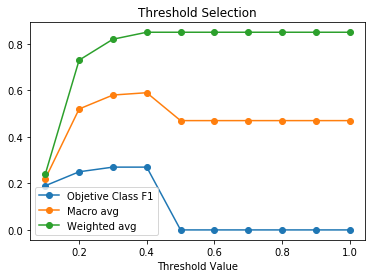

In [0]:

plt.plot(values, f1, 'o-')
plt.plot(values, macro, 'o-')
plt.plot(values, weighted, 'o-')
plt.gca().legend(('Objetive Class F1','Macro avg', 'Weighted avg'))
plt.title("Threshold Selection")
plt.xlabel("Threshold Value")
plt.savefig(SST_HOME + 'threshold_selection_a.eps', metadata="eps")